In [1]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt
from astropy.table import Column, join, Table, vstack, hstack
from astropy.io import ascii
from HMXB_pipeline_class import pipeline
import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
import corner
from datetime import datetime
import os
from astropy.io.votable import parse

In [2]:
from Galactic_traceback import GalacticTraceback

In [3]:
today = datetime.now().strftime("%Y%m%d")
int_time = -3.0 #integration time

# Colors

In [4]:
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    marker_map = {
        "xkcd:blue": 'o',   # Circle marker for "O I-III"
        "xkcd:red":'o',    # Circle marker for "B I-III"
        "xkcd:bright Blue": '^',  # Triangle marker for "Oe I-III"
        "xkcd:dark blue":'^',  # Triangle marker for "Oe IV-V"
        "xkcd:green": '^',  # Circle marker for "B0e I-III"
        "xkcd:bright green": '^',  # Circle marker for "B1e I-III"
        "xkcd:grass green":'^',  # Circle marker for "B2e I-III"
        "xkcd:black": 'x',   # Cross marker for "OB IV-V"
        "xkcd:grey": 'x',  # Cross marker for "M,A,None"
        "xkcd:purple": '^',  # Circle marker for "B0e IV-V"
        "xkcd:light purple": '^',  # Circle marker for "B1e IV-V"
        "xkcd:dark purple": '^'  # Circle marker for "B2e IV-V"
    }

# DNE This file

In [5]:
cwd = os.getcwd()
home_files = os.path.dirname(cwd)
home_files = home_files + '/'
csv_files  = home_files + 'DATA/'
csv_files

'/home/karan/Documents/UvA/Thesis/DATA/'

In [6]:
#HMXB_read = ascii.read(home_files+'HMXB_practice_analysis.ecsv',format='ecsv')
HMXB_read = ascii.read(csv_files+f'HMXB_{today}_.ecsv',format='ecsv')
#HMXB_read = ascii.read(csv_files+f'HMXB_20250224_.ecsv',format='ecsv')

In [7]:
HMXB_trace = HMXB_read

In [8]:
HMXB_trace

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,8.700283372674695,240.10342425051675,61.95124561277016,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.46936479892475763,-0.44992532117984846,-4.431322519296764,13.941189475632727,-2.8997578345443404,-4.89980074493557,0.09736027891056015,14.239570200483369,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.452638909302912,240.8838107733035,35.50056774678729,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.1463444758629011,0.011132043075021853,-6.514993682543146,10.921792847284518,-22.178684065983525,1.7453311518554506,0.04111130575412953,24.72204655560916,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.477343032770246,241.85577277691382,64.06117023428585,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.5022273305322419,-0.03456049782896494,-23.21298212009085,0.5253842437964262,--,0.03805491944081152,-0.02468244422842062,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,11.874963606736411,243.04361964900133,84.15072114876706,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.9355976382373346,0.13970778538641704,-55.12521551866847,8.74255457081801,2.3730377500976645,0.08268474684828575,-0.4390479579059345,9.05889444618489,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
414196617287

In [9]:
from astropy.table import MaskedColumn

masked_cols = [name for name in HMXB_trace.colnames if isinstance(HMXB_trace[name], MaskedColumn)]
print("Masked columns:", masked_cols)


Masked columns: ['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error', 'radial_velocity', 'radial_velocity_error', 'phot_g_mean_mag', 'ruwe', 'distance_bj', 'distance_bj_low', 'distance_bj_high', 'Name', 'Mx', 'Mx_err', 'Mo', 'Mo_err', 'RV', 'RV_err', 'Period', 'Period_err', 'Spin_period', 'Spin_period_err', 'pm_l_poleski', 'pm_b_poleski', 'mu_l_sol', 'mu_b_sol', 'mu_l_rot', 'mu_b_rot', 'Peculiar Velocity', 'Peculiar Radial Velocity', 'peculiar_mu_l', 'peculiar_mu_b', 'Peculiar Velocity 3D', 'dist_err', 'SpType']


In [10]:
#make a sample
HMXB_sample = HMXB_trace[1:20]
HMXB_sample

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.452638909302912,240.8838107733035,35.50056774678729,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.1463444758629011,0.011132043075021853,-6.514993682543146,10.921792847284518,-22.178684065983525,1.7453311518554506,0.04111130575412953,24.72204655560916,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.477343032770246,241.85577277691382,64.06117023428585,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.5022273305322419,-0.03456049782896494,-23.21298212009085,0.5253842437964262,--,0.03805491944081152,-0.02468244422842062,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,11.874963606736411,243.04361964900133,84.15072114876706,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.9355976382373346,0.13970778538641704,-55.12521551866847,8.74255457081801,2.3730377500976645,0.08268474684828575,-0.4390479579059345,9.05889444618489,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,--,--,11.412056,126.08000772759438,-3.5676859152271287,1.0861942,2.607235,2.499728,2.700093,EM* AS 14,--,--,--,--,--,--,--,--,--,--,2.9481710938070385,-2.3920245855272095,-0.800738525527853,9.908228429852588,241.32785437376185,158.3873947042304,1.3543735403539963,-0.6370991545909823,-4.149277022000289,-3.025490641480909,-0.17042466777322507,-41.0680036965889,8.909581185094764,--,-0.7209074844002972,0.006785296836354426,--,0.15678997907752415,B1-2 III/Ve,xkcd:green,xkcd:green
426558460884582016,14.177450998208093,1.8335997,60.716722804

In [11]:
def make_sky_simple(table):
    if 'ra' in table.colnames:
        ra = table['ra']
    elif 'RA_d' in table.colnames:
        ra = table['RA_d']
    else:
        raise ValueError("No valid RA column found in the table.")

    if 'dec' in table.colnames:
        dec = table['dec']
    elif 'DEC_d' in table.colnames:
        dec = table['DEC_d']
    skyobj = SkyCoord(ra=ra,dec=dec)
    galobj = skyobj.transform_to('galactic')

    table['l'] = galobj.l
    table['b'] = galobj.b
    return table

# Check with Mitchel's System LS 5039

In [12]:
ls5039 = HMXB_trace[HMXB_trace['Name'] == 'LS 5039']

In [13]:
ls5039['radial_velocity'] = 11.91
ls5039['radial_velocity_error'] =1.12

In [14]:
ls5039

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
4104196427943626624,276.5627681201673,0.012748371,-14.848438248314068,0.011323812,7.425312749534734,0.014174469,-8.151225884328909,0.011673848,0.4900256100180399,0.015014423,11.91,1.12,10.798686,16.881564472210624,-1.2892552605096488,0.749916,1.9012328,1.8470352,1.9708965,LS 5039,--,--,23.0,--,17.3,0.5,3.90607,8e-05,8.891,0.001,2.040709668139969,-3.7327492501273345,-10.375178836117982,6.355172911642472,237.17111763687163,87.67868081014093,-1.0960773575712812,-0.8787839022581286,-14.109344132673334,-0.7553868136164593,0.04832382968446789,15.088815925447,87.6704119522854,16.320528207226335,-1.881285078939594,-9.544718763544322,89.17657076186715,0.0625275040088767,ON6V((f))z,xkcd:blue,xkcd:blue


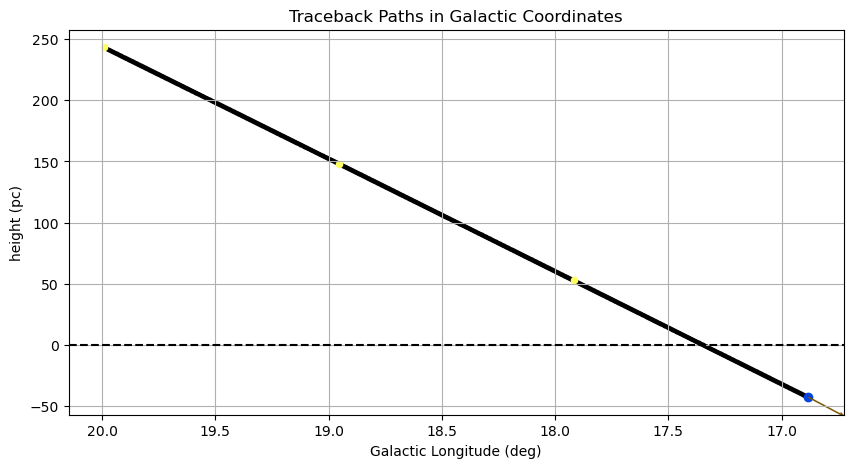

In [15]:
GalacticTraceback(ls5039,int_time=int_time).plot_trace(savefig=False)

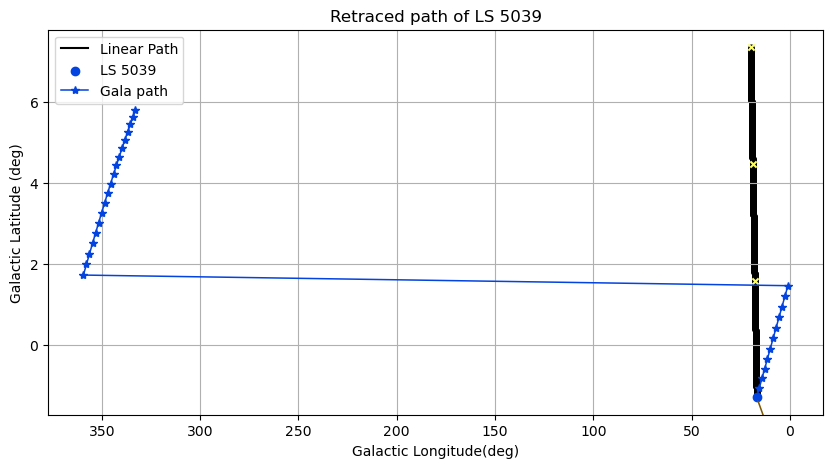

In [16]:
GalacticTraceback(ls5039,int_time=int_time).plot_with_cluster(ls5039['source_id'],clustertable=None,savefig=True)

# Check with 1700-37

In [17]:
star_170037 =HMXB_trace[HMXB_trace['Name'] == '4U 1700-377']
star_170037
#star_170037.write(home_files+"DATA/1700_37.csv",format='ascii.csv',overwrite=True)

# if 'radial_velocity' in star_170037.colnames and not np.isnan(star_170037['radial_velocity'][0]):
#     print(star_170037['radial_velocity'][0])

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
5976382915813535232,255.9865659301791,0.021049444,-37.8441202722809,0.012138224,2.4137032635492046,0.02806476,5.021949969731823,0.021347089,0.6327358617075665,0.025948899,--,--,6.4204698,347.75444710988126,2.173492429913019,0.8081919,1.5139931999999998,1.4613417,1.5923752,4U 1700-377,1.96,0.19,46.0,5.0,-60.0,10.0,3.41166,4e-06,--,--,1.5804383163952436,5.459355496184255,1.114173464609666,6.679230942389423,237.63301645326374,-61.001772677836,-2.171203317603579,-1.0177427454204167,-7.952405001432037,-0.3724851740513693,0.05825101462333499,-9.02673557992658,59.32909375406844,-43.02085941864138,8.003043987839204,2.0736651954067478,73.2853035116697,0.06481477741223182,O6Iafcp,xkcd:blue,xkcd:blue


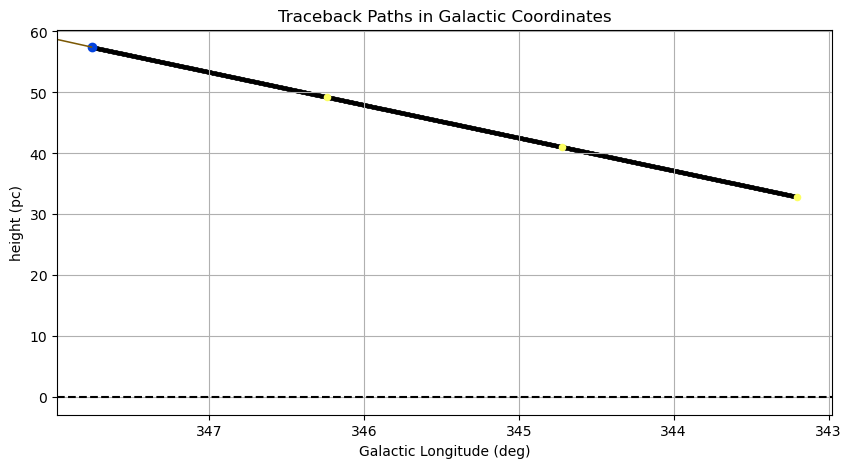

In [18]:
GalacticTraceback(star_170037,int_time=int_time).plot_trace(savefig=False)

In [19]:
ankay = ascii.read(csv_files+'/Ankay Stars-result.ecsv',format='ecsv')
ankay

source_id,l,b,parallax,parallax_error,ra,dec
,deg,deg,mas,mas,deg,deg
int64,float64,float64,float64,float32,float64,float64
2006888825592397440,105.32327905924795,-1.2939935497081787,0.3483052202515175,0.014516796,339.2247839218438,56.90581642753408
5620657678322625920,263.0582466143229,3.9298644181968547,0.49623999190934365,0.015160984,135.5285587975077,-40.55465296117549
5964986649547042944,343.0275230251908,0.8699789528790719,0.5855000591336458,0.11761477,253.49886248281086,-42.36204478621972
5966450786728068736,343.3618117479257,0.8883494689552196,0.615508231687669,0.03835648,253.76386970004768,-42.09084066377716
5966501501704611840,343.31111778593646,1.1041026694967573,0.5927086633224053,0.043056734,253.49521753918265,-41.994337526197754
5966509885480902656,343.4644354566207,1.1839131606480862,0.6916798090200686,0.0316925,253.541921539563,-41.825049016900444
5966510057279631488,343.46279853725764,1.2154956900689977,0.1598843584599856,0.34058267,253.50765128170775,-41.806400365822114
5966563486675142912,344.0836145646463,1.4908505152976395,0.5416667036863951,0.050578304,253.7437684795529,-41.15086637583546


In [20]:
#GalacticTraceback(star_170037).plot_with_cluster(star_170037['source_id'],ankay,savefig=False)

In [21]:
scoob1 = ascii.read(csv_files+'/SCO OB1-result.ecsv')

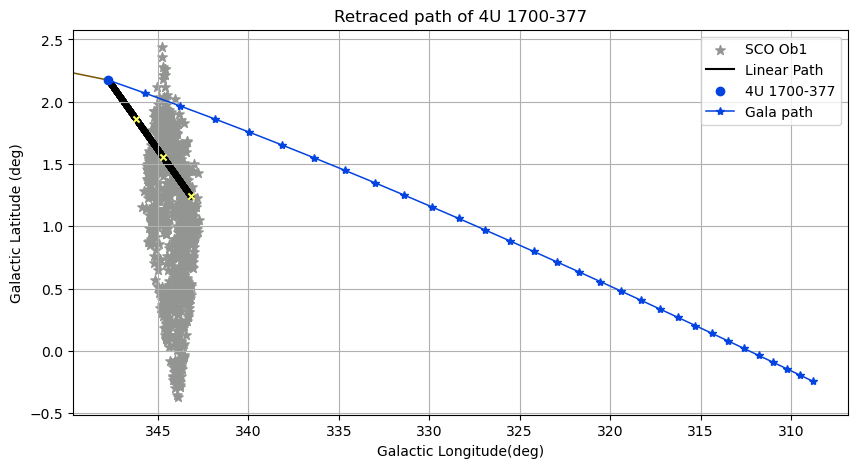

In [22]:

GalacticTraceback(star_170037,int_time=int_time).plot_with_cluster('SCO Ob1',clustertable=scoob1,savefig=True)

# 1700-37 with Ngc6231

In [23]:
star_170037

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
5976382915813535232,255.9865659301791,0.021049444,-37.8441202722809,0.012138224,2.4137032635492046,0.02806476,5.021949969731823,0.021347089,0.6327358617075665,0.025948899,--,--,6.4204698,347.75444710988126,2.173492429913019,0.8081919,1.5139931999999998,1.4613417,1.5923752,4U 1700-377,1.96,0.19,46.0,5.0,-60.0,10.0,3.41166,4e-06,--,--,1.5804383163952436,5.459355496184255,1.114173464609666,6.679230942389423,237.63301645326374,-61.001772677836,-2.171203317603579,-1.0177427454204167,-7.952405001432037,-0.3724851740513693,0.05825101462333499,-9.02673557992658,59.32909375406844,-43.02085941864138,8.003043987839204,2.0736651954067478,73.2853035116697,0.06481477741223182,O6Iafcp,xkcd:blue,xkcd:blue


In [24]:
Simbad.query_object('NGC6231')

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,matched_id
,deg,deg,mas,mas,deg,,,
object,float64,float64,float32,float32,int16,str1,object,object
NGC 6231,253.54499999999996,-41.812,--,--,--,O,2021A&A...647A..19T,NGC 6231


In [25]:
#plx, l,b,pm_l,pm_b, vrad banyard 2022
ngc6231 = [0.644688, 343.4762, 1.17, -2.05709, -0.929142, -28.16]
dist =1/ngc6231[0]
# Create the table
ngc_6231_param = Table([[dist], [ngc6231[1]], [ngc6231[2]], [ngc6231[3]], [ngc6231[4]], [ngc6231[5]]],
                        names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])

ngc_6231_param["distance_bj"].unit = u.kpc  # Parallax in milliarcseconds
ngc_6231_param["l"].unit = u.deg    # Galactic longitude in degrees
ngc_6231_param["b"].unit = u.deg    # Galactic latitude in degrees
ngc_6231_param["pm_l_poleski"].unit = u.mas/u.yr  # Proper motion in l in mas/yr
ngc_6231_param["pm_b_poleski"].unit = u.mas/u.yr  # Proper motion in b in mas/yr
ngc_6231_param["RV"].unit = u.km/u.s  # Radial velocity in km/s

ngc_6231_param.write(csv_files+'NGC2631_param.ecsv',format='ascii.ecsv',overwrite=True)

Minimum Seperation time -1.9000000000000006 Myr


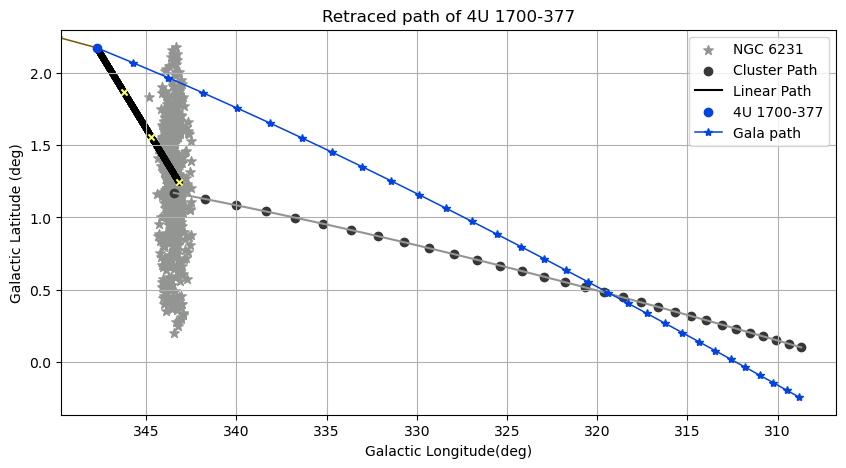

In [26]:
Ngc6231 = make_sky_simple(ascii.read(csv_files+'Ngc6231.ecsv',format='ecsv'))

GalacticTraceback(star_170037,int_time=int_time).plot_with_cluster('NGC 6231',cluster_params=ngc_6231_param, clustertable=Ngc6231,savefig=True)

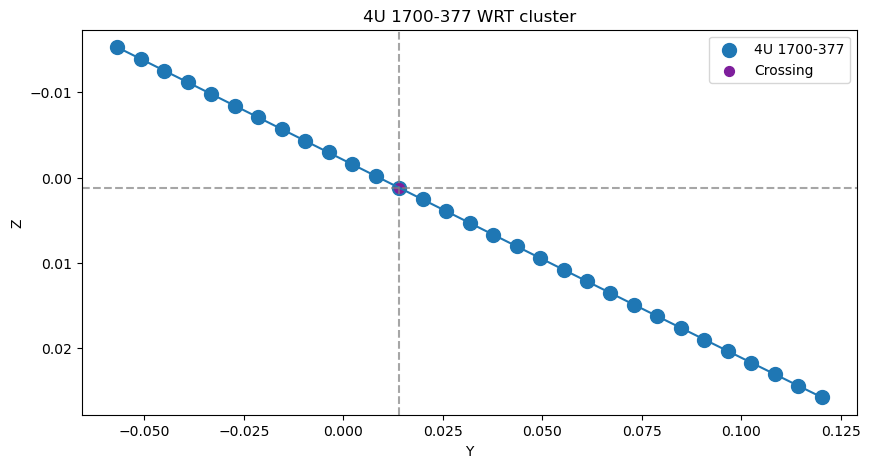

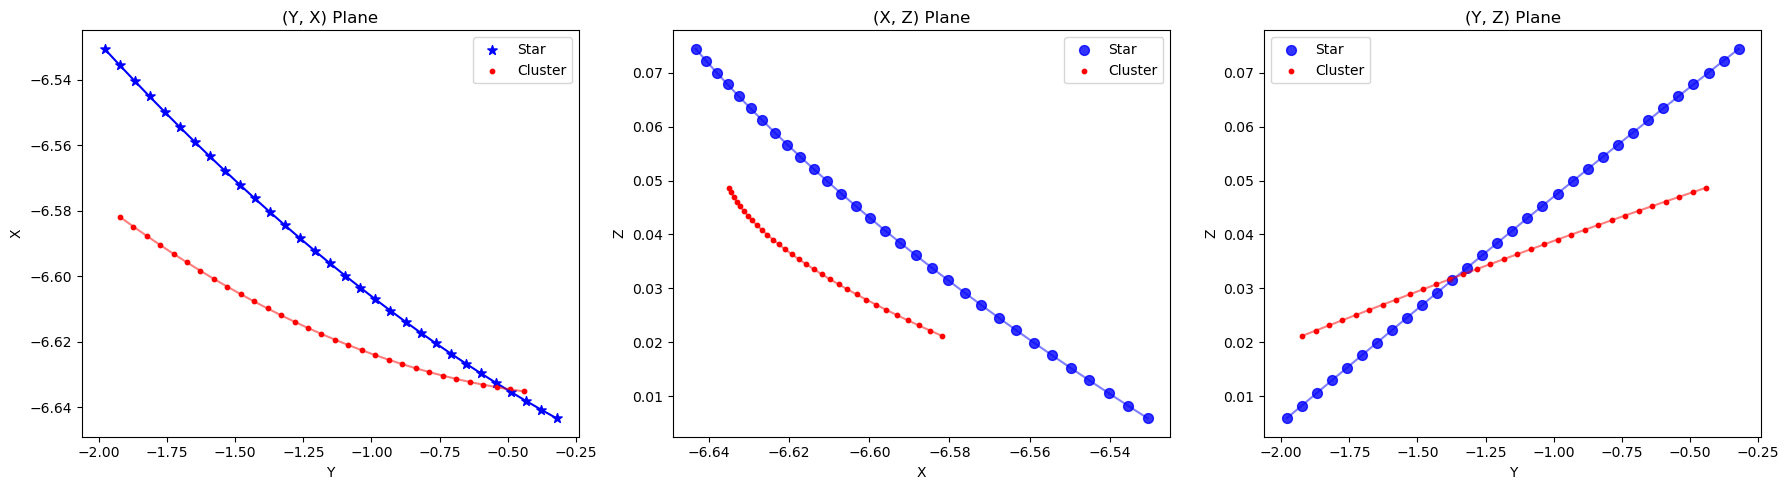

(array([-0.00822069, -0.00623816, -0.00425559, -0.00227293, -0.00029016,
         0.00169277,  0.00367588,  0.00565921,  0.00764278,  0.00962662,
         0.01161074,  0.01359517,  0.01557993,  0.01756502,  0.01955045,
         0.02153624,  0.02352239,  0.02550891,  0.02749578,  0.02948302,
         0.03147061,  0.03345855,  0.03544683,  0.03743543,  0.03942434,
         0.04141355,  0.04340303,  0.04539276,  0.04738272,  0.04937287,
         0.0513632 ]),
 array([ 0.12018302,  0.11429089,  0.10839733,  0.10250242,  0.09660624,
         0.09070887,  0.08481039,  0.07891088,  0.07301043,  0.06710911,
         0.06120702,  0.05530422,  0.04940082,  0.04349688,  0.0375925 ,
         0.03168776,  0.02578274,  0.01987752,  0.01397219,  0.00806683,
         0.00216152, -0.00374366, -0.00964863, -0.0155533 , -0.0214576 ,
        -0.02736145, -0.03326478, -0.0391675 , -0.04506955, -0.05097084,
        -0.05687131]),
 array([ 0.02576767,  0.02441925,  0.02306806,  0.02171424,  0.02035793,
     

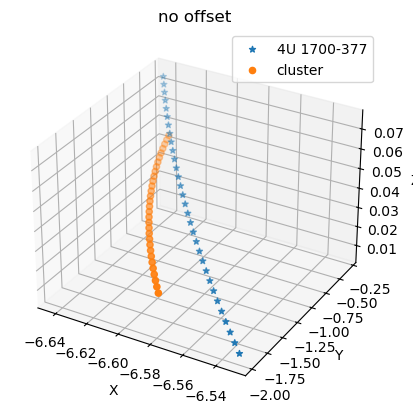

<Figure size 640x480 with 0 Axes>

In [27]:
GalacticTraceback(star_170037, int_time=-3.0).plot_comoving_cluster(star_170037,ngc_6231_param,plotting=True)

In [28]:
star_170037.write(csv_files+'Star1700377.ecsv',format='ascii.ecsv',overwrite=True)

# 1700-37 and UBC 323

Minimum Seperation time 0.0 Myr


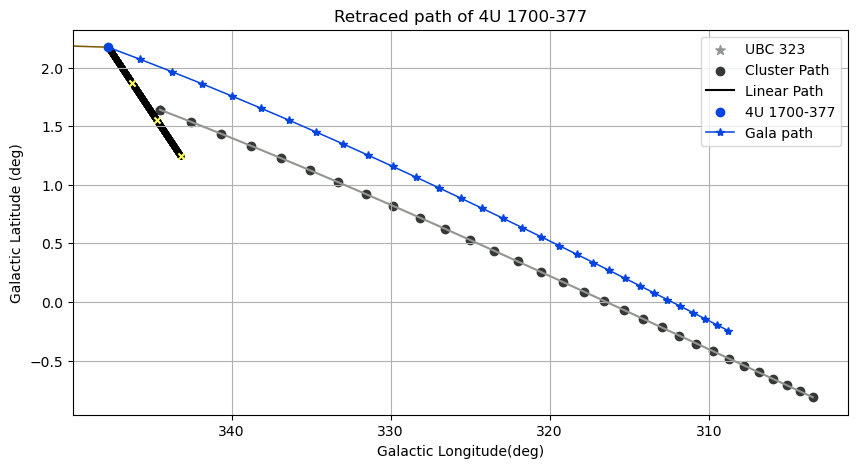

In [29]:
ubc323_query = Simbad.query_object('UBC_323')
ubc_ra = ubc323_query['ra'][0]
ubc_dec = ubc323_query['dec'][0]

ubc323_icrs = make_sky_simple(ubc323_query)

ubc323 = SkyCoord(ra=ubc_ra*u.deg, dec = ubc_dec*u.deg, distance=1.46*u.kpc, pm_ra_cosdec= -0.228*u.mas/u.yr, pm_dec=1.256 *u.mas/u.yr, 
                  radial_velocity=+40.21*u.km/u.s)

ubc323_galactic = ubc323.transform_to('galactic')


ubc323_params = Table([[ubc323_galactic.distance], [ubc323_galactic.l], [ubc323_galactic.b], [ubc323_galactic.pm_l_cosb], [ubc323_galactic.pm_b], 
                       [ubc323_galactic.radial_velocity]],
                        names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])

ubc323_params.write(csv_files+'UBC323_param.ecsv',format='ascii.ecsv',overwrite=True)

GalacticTraceback(star_170037,int_time).plot_with_cluster('UBC 323', cluster_params=ubc323_params, clustertable=ubc323_icrs,savefig=False)

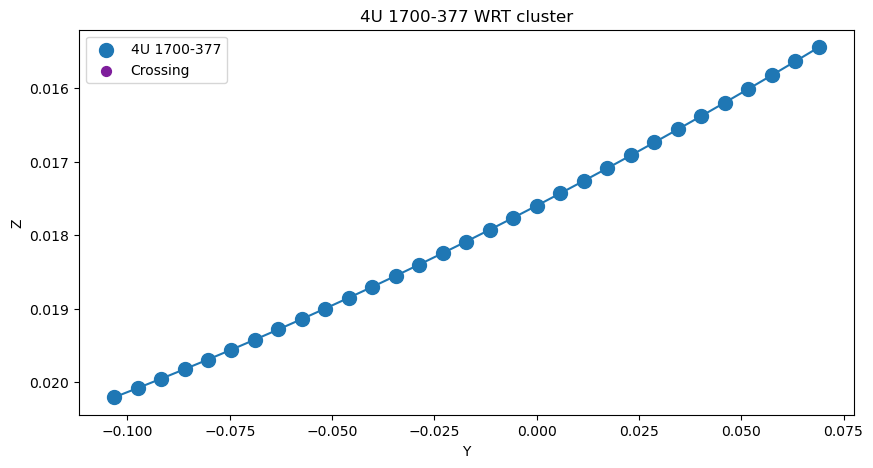

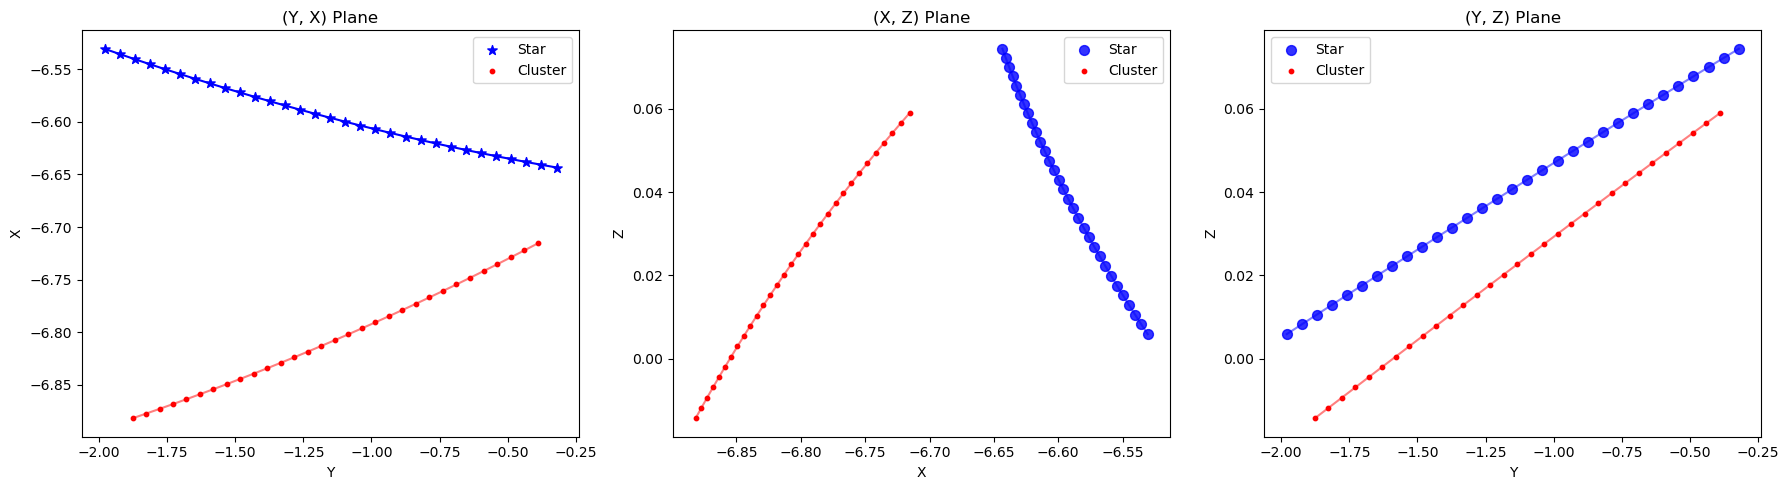

(array([0.0721618 , 0.08143597, 0.09071113, 0.09998741, 0.10926491,
        0.11854372, 0.12782395, 0.1371057 , 0.14638906, 0.15567411,
        0.16496095, 0.17424965, 0.18354029, 0.19283295, 0.20212771,
        0.21142462, 0.22072375, 0.23002516, 0.23932892, 0.24863506,
        0.25794364, 0.26725471, 0.2765683 , 0.28588446, 0.29520321,
        0.30452459, 0.31384862, 0.32317532, 0.33250472, 0.34183682,
        0.35117164]),
 array([ 6.89894673e-02,  6.32431808e-02,  5.74962368e-02,  5.17487384e-02,
         4.60007915e-02,  4.02525050e-02,  3.45039907e-02,  2.87553630e-02,
         2.30067390e-02,  1.72582381e-02,  1.15099822e-02,  5.76209526e-03,
         1.47033199e-05, -5.73206560e-03, -1.14780817e-02, -1.72232134e-02,
        -2.29673278e-02, -2.87102905e-02, -3.44519656e-02, -4.01922164e-02,
        -4.59309050e-02, -5.16678927e-02, -5.74030400e-02, -6.31362068e-02,
        -6.88672525e-02, -7.45960362e-02, -8.03224166e-02, -8.60462526e-02,
        -9.17674028e-02, -9.74857262e-

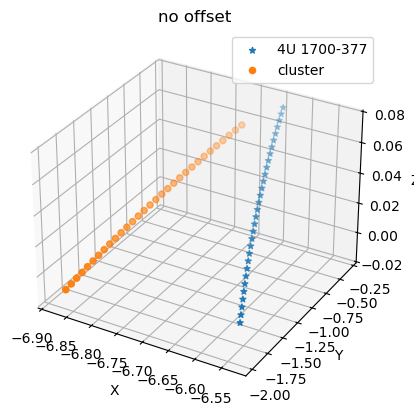

<Figure size 640x480 with 0 Axes>

In [30]:
GalacticTraceback(star_170037, int_time=-3.0).plot_comoving_cluster(star_170037,ubc323_params,plotting=True)

# For 4U 2206 + 54 and CEP OB1

In [31]:
cepob1 = Simbad.query_object('Cep Ob1')
cep_sky = SkyCoord(ra=cepob1['ra'],dec=cepob1['dec'])
cep_gal = cep_sky.transform_to('galactic')
cepob1['l'] = cep_gal.l
cepob1['b'] = cep_gal.b

In [32]:
##plx, l,b,pm_l,pm_b, vrad Mel'nik 2017
cep_ob1_params = Table([[2.78]*u.kpc, cepob1['l'],cepob1['b'], [-4.46]*u.mas/u.yr,[-0.67]*u.mas/u.yr,[-58.2]*u.km/u.s],
                       names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])
cep_ob1_params

distance_bj,l,b,pm_l_poleski,pm_b_poleski,RV
kpc,deg,deg,mas / yr,mas / yr,km / s
float64,float64,float64,float64,float64,float64
2.78,104.23444402650125,-1.0102387683410685,-4.46,-0.67,-58.2


Minimum Seperation time 0.0 Myr


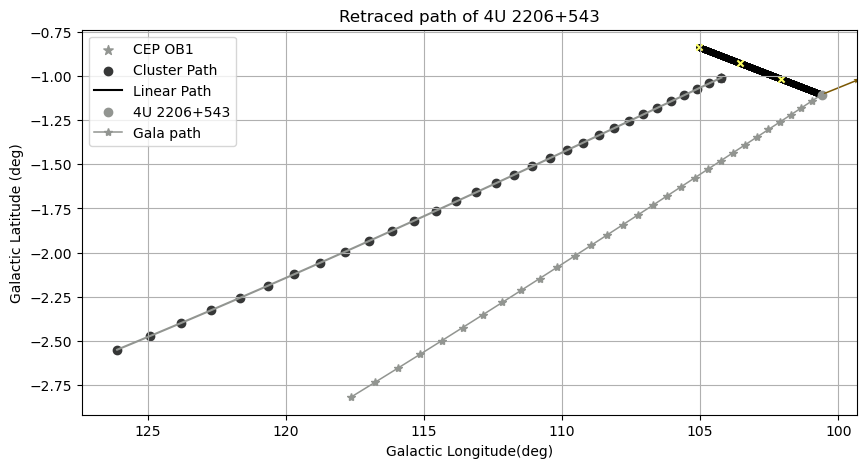

In [33]:
FU220654 = HMXB_trace[HMXB_trace['Name'] == '4U 2206+543']
FU220654['RV'] = -62.7
GalacticTraceback(FU220654,int_time=int_time).plot_with_cluster(clustername='CEP OB1',cluster_params=cep_ob1_params, clustertable=cepob1, savefig=True)

Simbad.add_votable_fields('plx_value')
cepob1 = Simbad.query_object('Cep Ob1')

# 4U 2206 + 543 and NGC 7380

Minimum Seperation time -3.0000000000000013 Myr


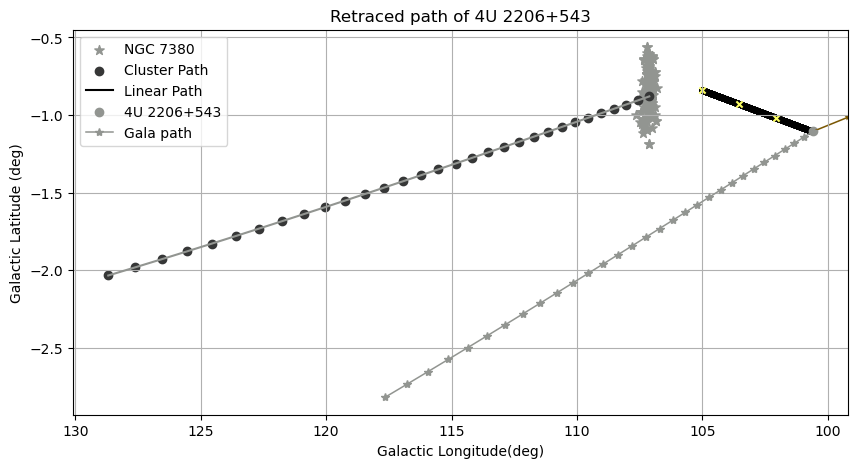

distance_bj,l,b,pm_l_poleski,pm_b_poleski,RV
kpc,deg,deg,mas / yr,mas / yr,km / s
float64,float64,float64,float64,float64,float64
3.003003003003003,107.12,-0.88,-4.46,-0.67,-58.2


In [34]:
Ngc7380 = make_sky_simple(ascii.read(csv_files+'Ngc7380.ecsv',format='ecsv'))
ngc7380_params = Table([[1/0.333]*u.kpc, [107.12]*u.deg,[-0.88]*u.deg, [-4.46]*u.mas/u.yr,[-0.67]*u.mas/u.yr,[-58.2]*u.km/u.s],
                       names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])
GalacticTraceback(FU220654,int_time).plot_with_cluster("NGC 7380",cluster_params=ngc7380_params,clustertable=Ngc7380,savefig=True)
ngc7380_params

In [35]:
cepob1

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,plx_value,matched_id
,deg,deg,mas,mas,deg,,,mas,
object,float64,float64,float32,float32,int16,str1,object,float64,object
Ass Cep OB 1,337.25,56.6,--,--,--,,2003AstL...29..311S,--,Ass Cep OB 1


# Berkley 97 and 4U 2206+54

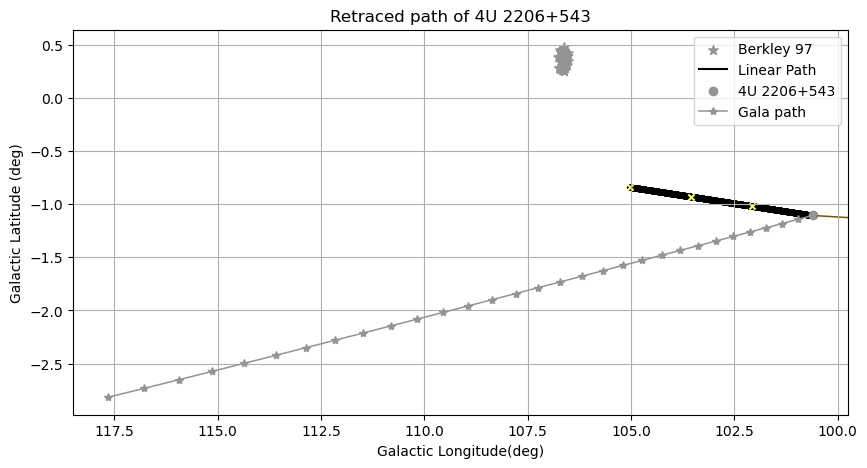

In [36]:
Berkley97 = ascii.read(csv_files+'Berkley_97.ecsv',format='ecsv')
GalacticTraceback(FU220654,int_time=int_time).plot_with_cluster(clustername='Berkley 97',clustertable=Berkley97,savefig=True)

# Cygnus X-1 and CYG 0B8


In [37]:
CYGX1 = HMXB_trace[HMXB_trace['Name'] == 'Cyg X-1']

CYGOB8 = Simbad.query_object("Cyg OB8") #ascii.read(csv_files+'NAME VI Cyg.html',format='html')


In [38]:
CYGOB8 = make_sky_simple(CYGOB8)
CYGOB8
#from Mel-nik 2017
cygob8_params =  Table([[1.83]*u.kpc, [77.91]*u.deg,[3.36]*u.deg, [-6.27]*u.mas/u.yr,[0.53]*u.mas/u.yr,[-21.0]*u.km/u.s],
                       names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])

In [39]:
CYGX1['RV'] = -7.0 * u.km/u.s

Minimum Seperation time -3.0000000000000013 Myr


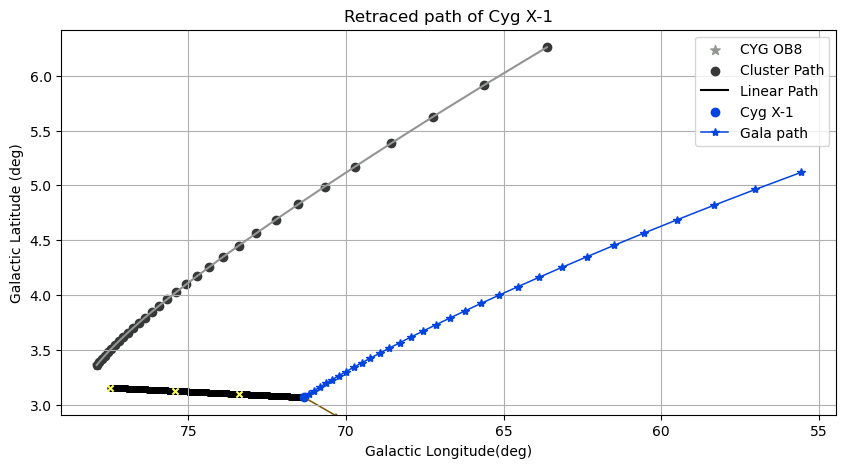

In [40]:
GalacticTraceback(CYGX1,int_time=int_time).plot_with_cluster(clustername='CYG OB8',cluster_params=cygob8_params, clustertable=CYGOB8,savefig=True)

# CYG X-1 and NGC 6871

Minimum Seperation time -0.7999999999999999 Myr


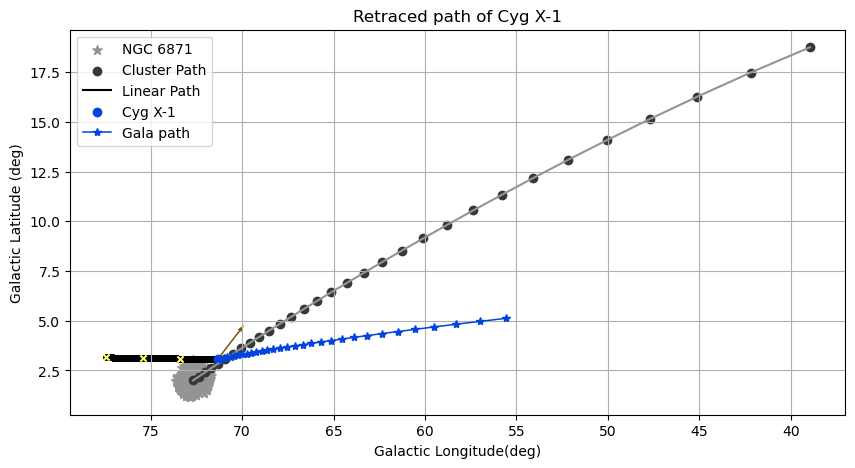

In [41]:
Ngc6871 = make_sky_simple(ascii.read(csv_files+'Ngc6871.ecsv',format='ecsv'))
Ngc6871_icrs = Table([[1/0.514]*u.kpc, [20.06]*u.deg,[+35.45]*u.deg, [-3.129]*u.mas/u.yr,[-6.437]*u.mas/u.yr,[-10.5]*u.km/u.s],
                       names=["distance_bj", "ra", "dec", "pmra", "pmdec", "RV"])

Ngc6871_gal = pipeline(table_name='Ngc6871_gal',fmt='ecsv').transform_pm(Ngc6871_icrs)


ngc_6871_params  =  Table([[1/0.514]*u.kpc, [Ngc6871['l'].mean()]*u.deg,[Ngc6871['b'].mean() ]*u.deg, Ngc6871_gal['pm_l_poleski'] ,Ngc6871_gal['pm_b_poleski'],[-10.5]*u.km/u.s],
                       names=["distance_bj", "l", "b", "pm_l_poleski", "pm_b_poleski", "RV"])
GalacticTraceback(CYGX1,int_time=int_time).plot_with_cluster(clustername='NGC 6871',cluster_params=ngc_6871_params, clustertable=Ngc6871,savefig=True)

In [42]:
ngc_6871_params

distance_bj,l,b,pm_l_poleski,pm_b_poleski,RV
kpc,deg,deg,mas / yr,mas / yr,km / s
float64,float64,float64,float64,float64,float64
1.9455252918287937,72.6887082246567,1.992862825863135,-2.2309096664730013,-6.800636151128607,-10.5


# Vela X-1 and RCW 38

In [43]:
RCW38 = make_sky_simple(ascii.read(csv_files+'RCW_38.ecsv',format='ecsv'))
velax1 = HMXB_trace[HMXB_trace['Name']=='Vela X-1']

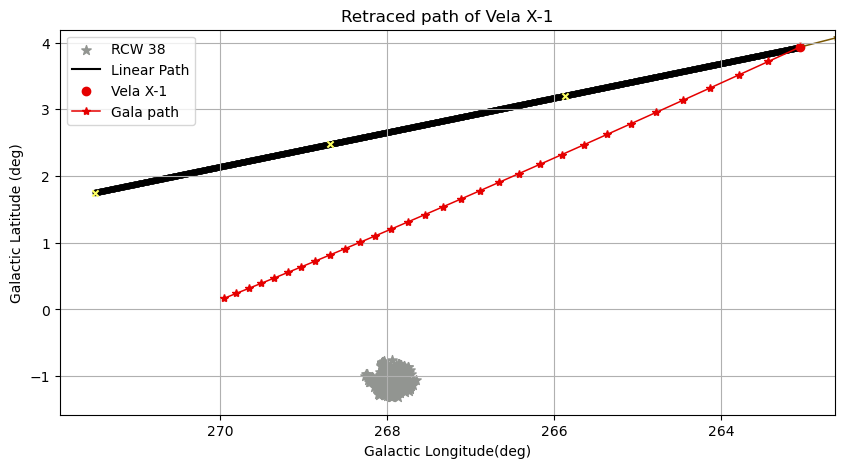

In [44]:
GalacticTraceback(velax1,int_time=int_time).plot_with_cluster(clustername='RCW 38',clustertable=RCW38,savefig=True)

# Vela X-1 and Platais 9

In [45]:
Platais9 = make_sky_simple(ascii.read(csv_files+'Platais9.ecsv',format='ecsv'))

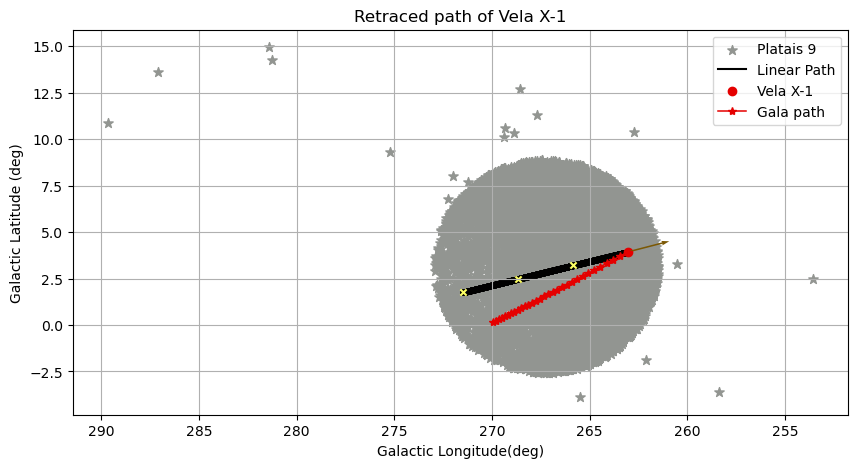

In [46]:
GalacticTraceback(velax1,int_time=int_time).plot_with_cluster('Platais 9',clustertable=Platais9,savefig=True)

# Converting astropy table list to float. Used in Galactic_traceback

very dumb

In [47]:
# x = HMXB_sample[HMXB_sample['source_id'] == 427234969757165952]
# #float(x['l'][0])
# l = float(x['l'][0])
# l


In [48]:
HMXB_sample = GalacticTraceback(HMXB_sample,int_time=int_time).traceback_time()

In [49]:
HMXB_trace = GalacticTraceback(HMXB_trace,int_time=int_time).traceback_time()

In [50]:
HMXB_trace.write(home_files+f"Trace_{today}.csv",format='ascii.csv',overwrite=True)

In [51]:
# GalacticTraceback(HMXB_sample).plot_trace(savefig=False)

0 11


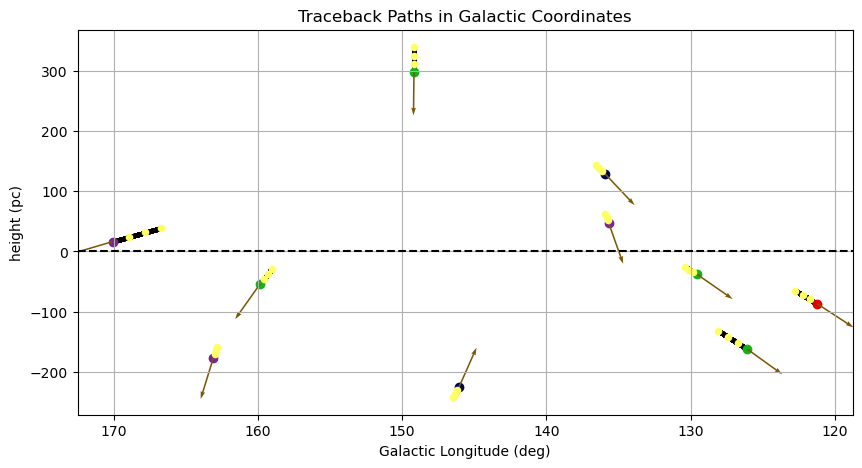

11 22


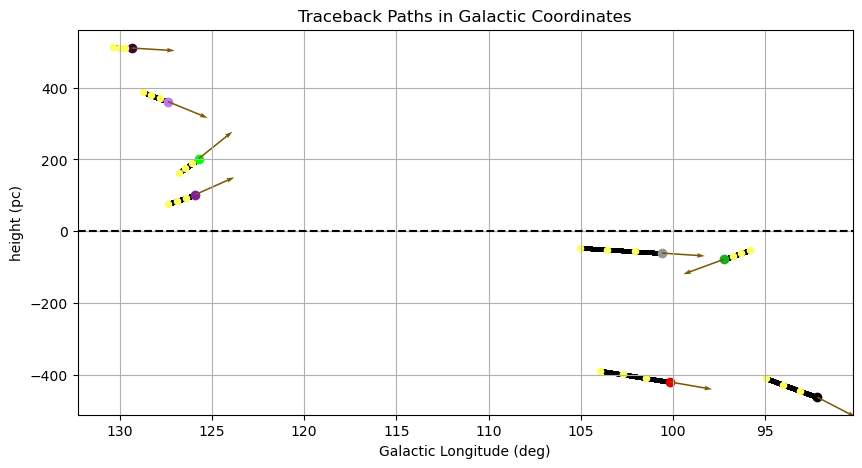

22 33


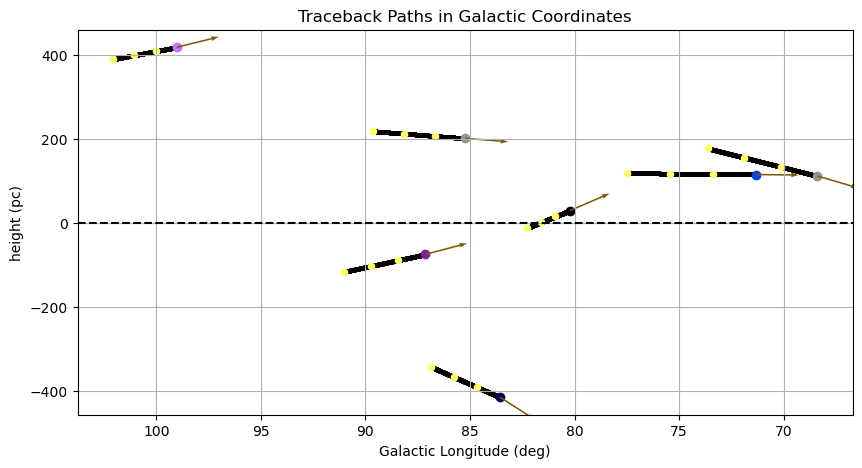

33 44


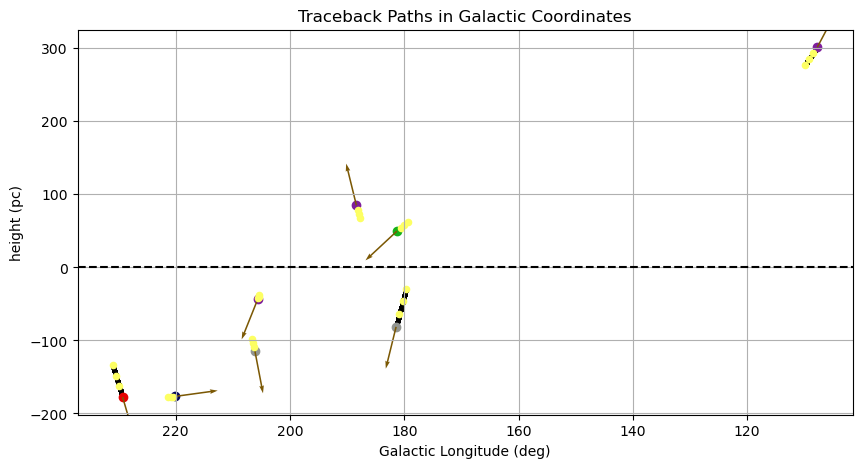

44 55


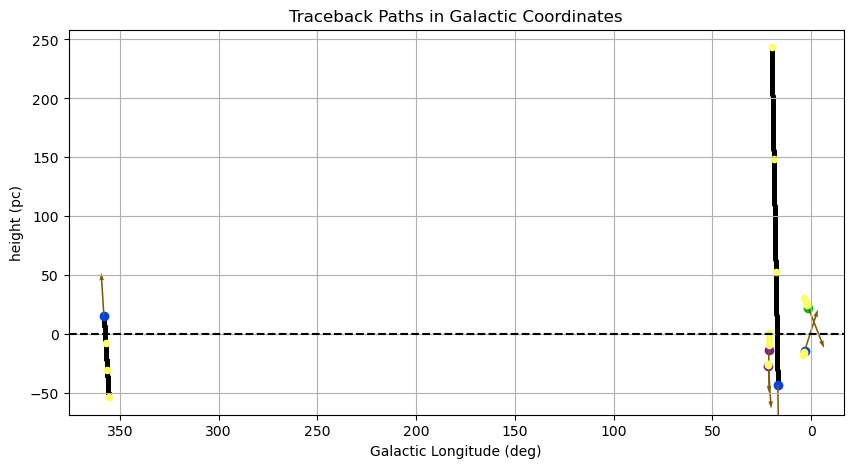

55 66


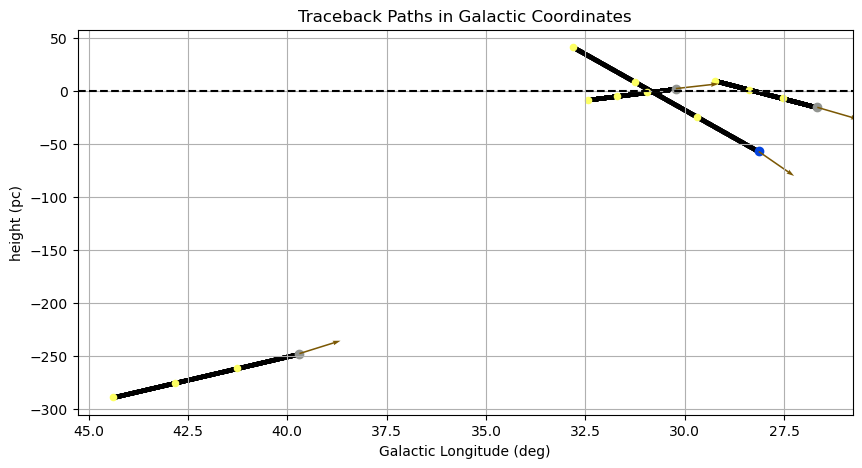

66 77


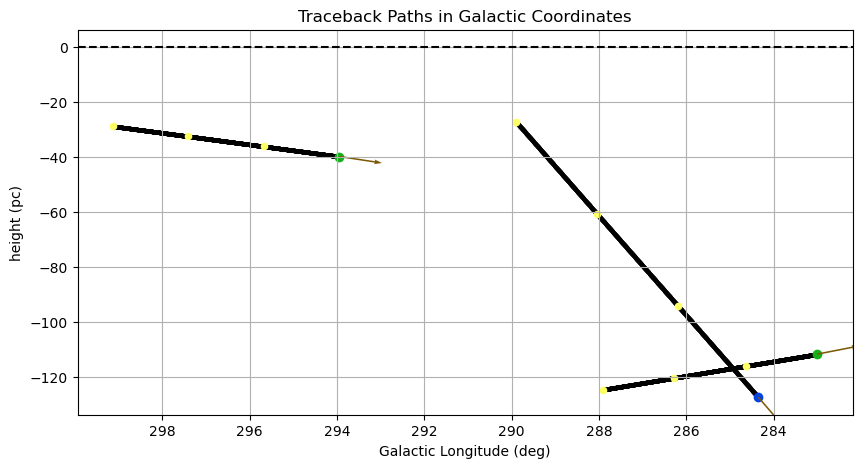

77 88


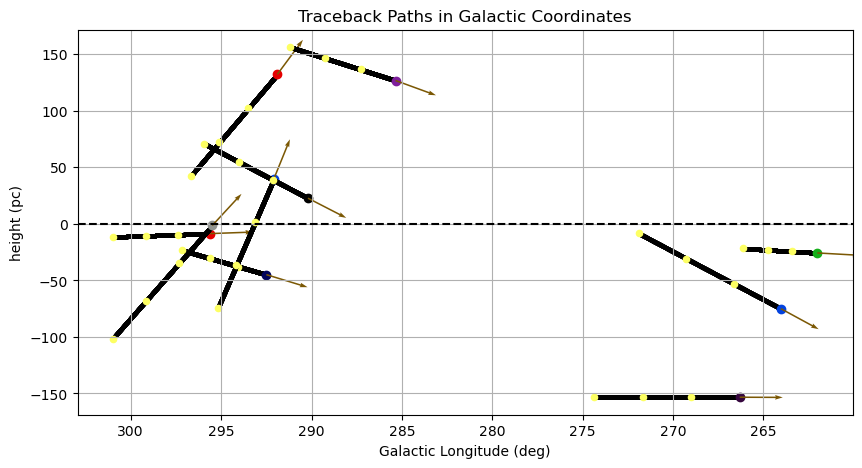

88 99


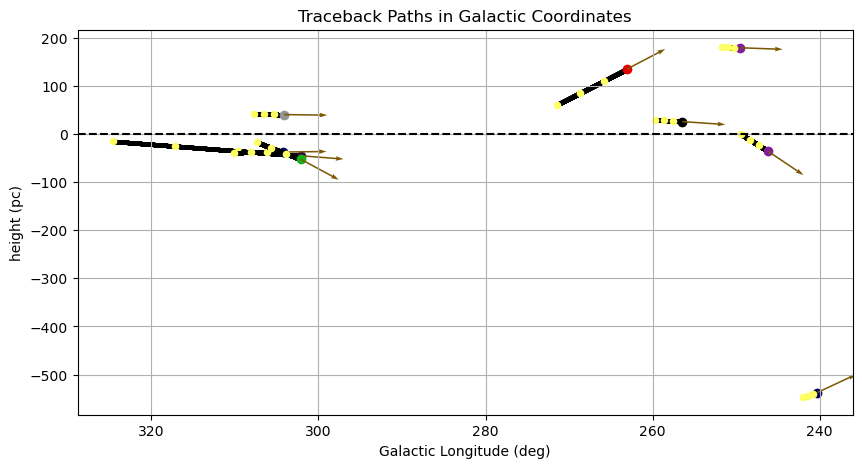

99 110


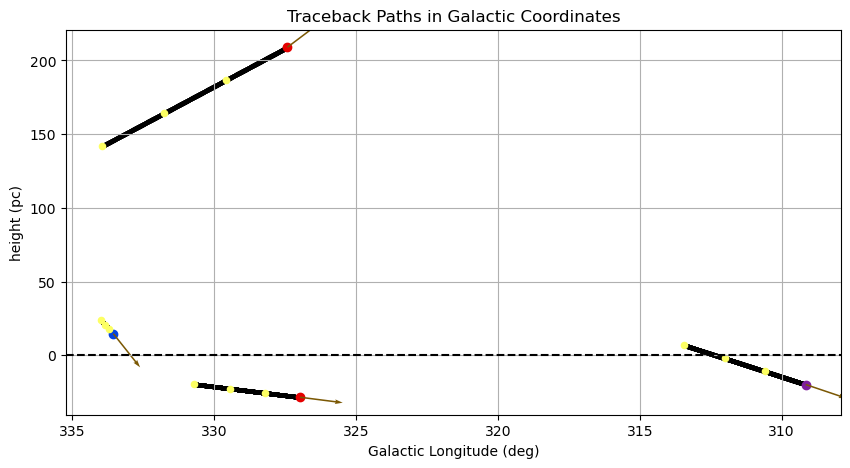

110 121


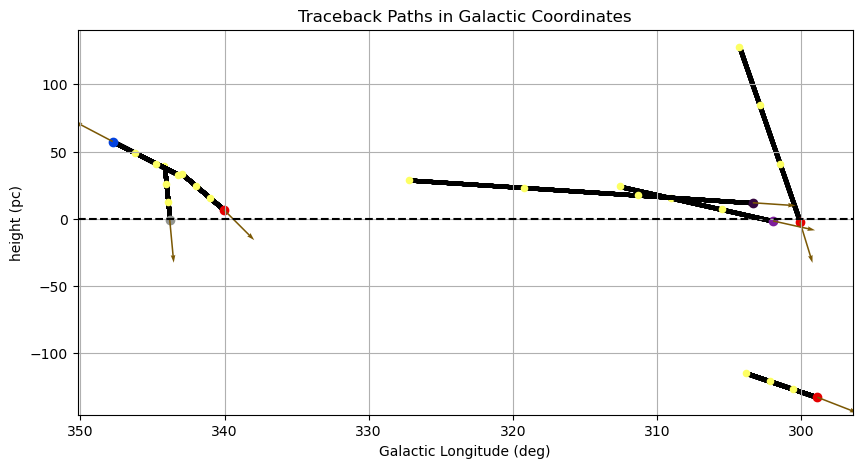

In [52]:
see_idx = np.linspace(0,121,12)
see_idx 

for i in range(len(see_idx)-1):
    a = int(see_idx[i])
    b = int(see_idx[i+1])
    print(a,b)
    GalacticTraceback(HMXB_trace[a:b],int_time=int_time).plot_trace(savefig=False)
    

In [53]:
intersting_index = [5,9,14,16,35,42,47,74,105]
#for indexing subtract 2
intersting_index = [x -2 for x in intersting_index]
intersting_index
interesting_stars = HMXB_trace[intersting_index]

In [54]:

interesting_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,11.874963606736411,243.04361964900133,84.15072114876706,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.9355976382373346,0.13970778538641704,-55.12521551866847,8.74255457081801,2.3730377500976645,0.08268474684828575,-0.4390479579059345,9.05889444618489,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green,-21.402438098253675
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,--,--,14.200214,146.05208942276994,-2.1940257086354467,1.0700557,5.883423,5.4845513,6.3010405,V 0332+53,--,--,18.8,--,--,--,36.5,0.29,4.4,--,7.4433963546230135,-0.4757472370713855,0.19806512394601175,13.4343354203113,244.21979884912392,81.47805821038516,0.6208160537405135,-0.27045155073291544,1.65427792924791,-0.9427488161555174,-0.07116499591209231,-85.389013145311,15.649671507668813,--,-0.15381447465638154,0.5396816705910196,--,1.11646689171978,O8-9Ve,xkcd:dark blue,xkcd:blue,-39.87826020920556
519352324516039680,23.95771733364349,0.0074431454,66.21202346679833,0.008329693,-1.6256635994947488,0.00863042,-0.02743521083805346,0.011114323,0.1668629279602417,0.01096499,--,--,12.461553,127.39442158128841,3.7256576059257593,1.053552,5.563626500000001,5.248088399999999,5.9916035,IGR J01363+6610,--,--,12.5,--,--,--,159.0,2.0,--,--,5.9929429036404605,-1.5939762607956323,-0.32058463708656854,12.337078133540114,243.40694447131082,125.77717053988418,0.6385499035475829,-0.27711774582794346,-4.730887622433924,-2.1873251476018836,0.15679355650174195,-96.12275557895667,5.41404167184289,--,-0.04520101674133148,-0.20026044776036703,--,0.39381160205970045,B1Ve,xkcd:light purple,xkcd:green,-41.837211861499604
524924310153249920,19.511227046863358,0.0074612005,65.29162260285469,0.00889375,-1.2433985583085483,0.009154735,0.7606173957665759,0.011805355,0.1964171573898191,0.011268352,--,--,10.520529,125.70997540875491,2.563488419804798,0.94464165,4.5270576,4.3225546999999995,4.8506323,2S 0114+650,--,--,16.0,2.0,-31.0,5.0,11.5983,0.0006,10008.0,36.0,5.091204929798221,-1.3209841517227512,0.6161003720529863,11.397508308296436,242.65367986781396,139.00787288065314,0.7786042931208563,-0.34394356243495516,-5.0743600444446795,-2.5374927243580867,0.1138067905909506,-76.28096804664884,20.445982245459895,50.35532809109352,0.4379042795144792,0.84623

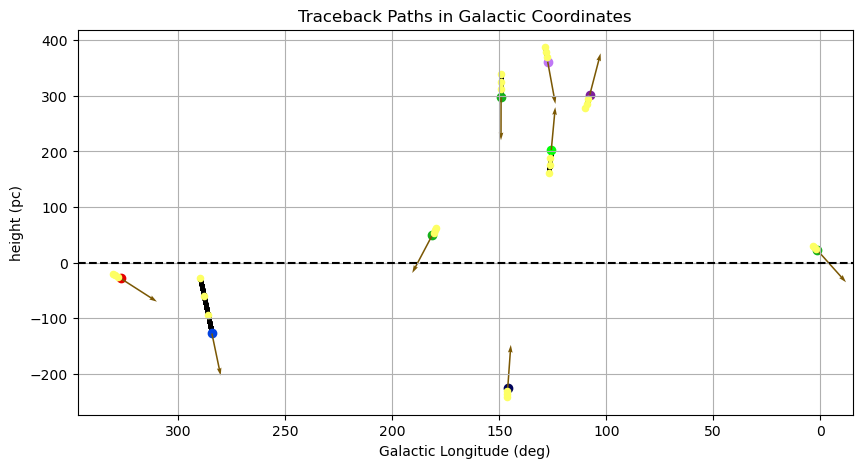

In [55]:
GalacticTraceback(interesting_stars,int_time=int_time).plot_trace(savefig=False)

In [56]:
HMXB_sample.write(home_files+"DATA/sample_path.csv",format='ascii.csv',overwrite=True)

In [57]:
leaving_stars_mask = HMXB_trace['Trace Time'] > 0
leaving_stars = HMXB_trace[leaving_stars_mask]
leaving_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor,Trace Time
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,km / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,,Million years
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,8.700283372674695,240.10342425051675,61.95124561277016,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.46936479892475763,-0.44992532117984846,-4.431322519296764,13.941189475632727,-2.8997578345443404,-4.89980074493557,0.09736027891056015,14.239570200483369,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green,27.475025011659326
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.477343032770246,241.85577277691382,64.06117023428585,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.5022273305322419,-0.03456049782896494,-23.21298212009085,0.5253842437964262,--,0.03805491944081152,-0.02468244422842062,--,0.10482196429390027,B0e,xkcd:green,xkcd:green,6.4871966954926545
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,--,--,11.412056,126.08000772759438,-3.5676859152271287,1.0861942,2.607235,2.499728,2.700093,EM* AS 14,--,--,--,--,--,--,--,--,--,--,2.9481710938070385,-2.3920245855272095,-0.800738525527853,9.908228429852588,241.32785437376185,158.3873947042304,1.3543735403539963,-0.6370991545909823,-4.149277022000289,-3.025490641480909,-0.17042466777322507,-41.0680036965889,8.909581185094764,--,-0.7209074844002972,0.006785296836354426,--,0.15678997907752415,B1-2 III/Ve,xkcd:green,xkcd:green,16.039779385350563
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,--,--,9.454656,121.22141620023214,-1.4641898756122689,0.97518367,3.40784,3.2624436,3.5502334,IGR J00370+6122,--,--,22.0,--,-80.0,3.0,15.6649,0.0014,674.0,--,3.677948996847052,-1.8178140519374264,-0.4422414945716403,10.33498447483242,241.7263509582219,161.12538913612698,1.0081838839954012,-0.47988460641303254,-5.836009540939745,-3.2159193819642735,-0.0674952538869339,-54.089587838333074,6.523414064590358,-20.07440262072718,0.3899214460314462,0.10513836572832615,21.107737245786286,0.16313775201

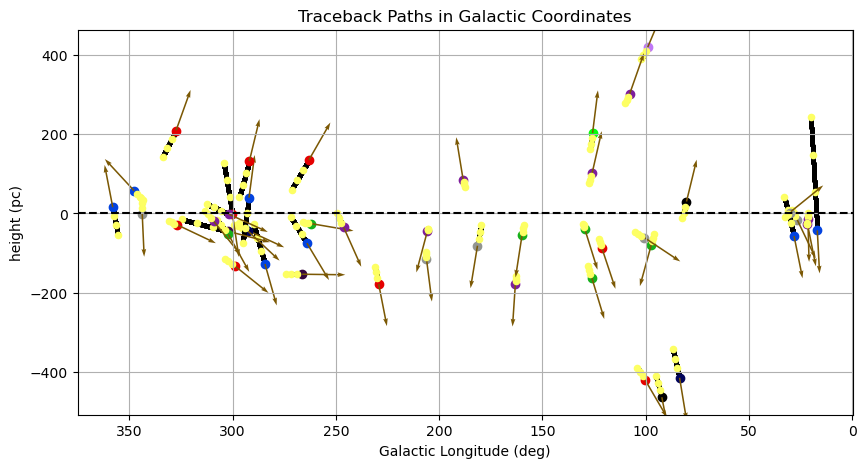

In [58]:
GalacticTraceback(leaving_stars,int_time=int_time).plot_trace(savefig=True)

In [59]:
approaching_stars_mask = HMXB_trace['Trace Time'] < 0
approaching_stars = HMXB_trace[approaching_stars_mask]

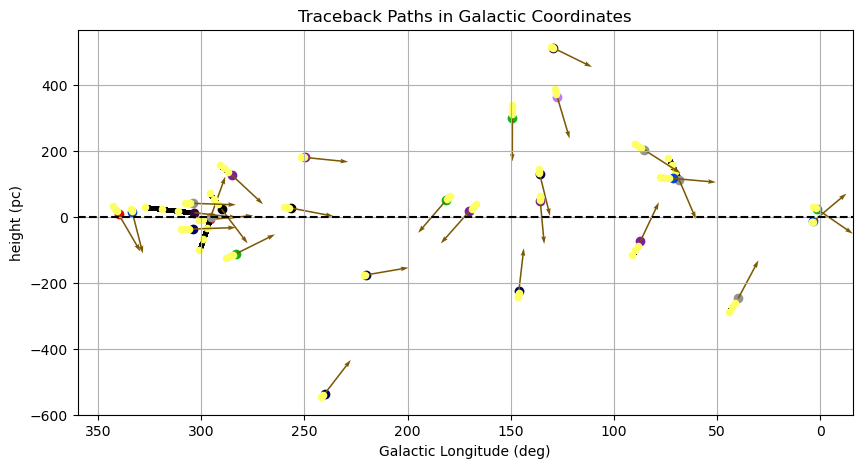

In [60]:
GalacticTraceback(approaching_stars,int_time).plot_trace(savefig=False)